In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import torch
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
import warnings

In [20]:
def load_data(data_path, desc_flag, max_token_length=256, cut=512):
    
    games = ["Alien", "IceHockey", "Pong", "AirRaid", "SpaceInvaders"]
    data = None

    for game in games:
        file_path = f"{data_path}/{game}.pkl"
        game_data = pd.read_pickle(file_path)
        if game == "Alien":
            text = "In Alien, players take on the role of a lone astronaut stranded aboard a space station infested with deadly aliens. \
                    The objective is to survive wave after wave of relentless alien attacks while attempting to escape the doomed station. \
                    The game features a top-down perspective, with the player navigating through maze-like corridors filled with lurking aliens. \
                    Armed with a limited supply of ammunition, players must strategically defend themselves against the alien onslaught. \
                    The tension mounts as the aliens grow increasingly aggressive and numerous with each passing level."
        elif game == "IceHockey":
            text = "In Ice Hockey, players take control of a team of ice hockey players in a thrilling one-on-one matchup against the computer or another player. \
                    The game features simple yet engaging gameplay mechanics, with players maneuvering their skaters across the icy rink to outmaneuver the opposition and score goals. \
                    Using the joystick controller, players can control the direction and speed of their skaters, as well as perform actions such as passing, shooting, and checking."
        elif game == "Pong":
            text = "In Pong, two players control paddles on either side of the screen, with the goal of hitting a ball back and forth between them. \
                    The paddles move vertically and are controlled by players using knobs or joysticks. \
                    The objective is to score points by successfully hitting the ball past the opponent's paddle. \
                    The game features simple graphics consisting of two-dimensional paddles and a square ball bouncing across the screen. \
                    As the game progresses, the ball's speed increases, making it more challenging for players to react and hit the ball."
        elif game == "AirRaid":
            text = "In Air Raid, players must fend off waves of enemy aircraft while strategically managing their ammunition and fuel supplies. \
                    The game unfolds with the player's jet stationed at the bottom of the screen, with a city skyline serving as the backdrop. \
                    Enemy aircraft, depicted as various geometric shapes, descend from the top of the screen in relentless waves, unleashing barrages of projectiles as they attempt to destroy the player's jet and the city below. \
                    Players control the fighter jet using the joystick controller, maneuvering left and right to evade enemy fire while returning fire to eliminate incoming threats. \
                    The game's challenging mechanics require players to balance offensive and defensive strategies, carefully conserving ammunition and fuel to survive each increasingly difficult wave of attacks."
        elif game == "SpaceInvaders":
            text = "In Space Invaders, players control a movable laser cannon situated at the bottom of the screen, aiming to eliminate descending formations of pixelated alien invaders. \
                    The invaders gradually advance towards the bottom of the screen, firing back at the player in a coordinated assault. \
                    As the player successfully shoots down aliens, the game's pace intensifies, with the remaining invaders moving faster and adopting more aggressive attack patterns. \
                    Players must strategically dodge incoming enemy fire while aiming carefully to eliminate as many aliens as possible."
        else:
            text = None

        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        
        if desc_flag == 0:
            tokens = tokenizer.encode(text, max_length=max_token_length, truncation=True, padding='max_length')
            tokens = tokenizer.convert_tokens_to_ids(tokens)
            game_data['Text'] = [tokens] * len(game_data)

        elif desc_flag == 1:
            tokens = tokenizer(text, padding=True, truncation=True, return_tensors='pt', max_length=256)
            model = BertModel.from_pretrained('bert-base-cased')
            with torch.no_grad():
                outputs = model(**tokens)
                embeddings = outputs.last_hidden_state[:, 0, :].numpy()  # Use [CLS] token embeddings
            embeddings = np.squeeze(embeddings)
            game_data['Text'] = [embeddings] * len(game_data)

        else:
            tokens = tokenizer(text, padding=True, truncation=True, return_tensors='pt', max_length=256)
            model = BertModel.from_pretrained('bert-base-cased')
            # Forward pass to obtain BERT embeddings
            with torch.no_grad():
                outputs = model(**tokens)
                hidden_states = outputs.last_hidden_state

            # Calculate the mean of the hidden states across all tokens for each text
            mean_hidden_states = torch.mean(hidden_states, dim=1).numpy()
            mean_hidden_states = np.squeeze(mean_hidden_states)
            game_data['Text'] = [mean_hidden_states] * len(game_data)

            
        game_data['Game'] = [game] * len(game_data)
        if data is None:
            data = game_data
        else:
            data = pd.concat([data, game_data], ignore_index=True)

    # Exclude all the rows with an Action or a Reward smaller than cut
    data = data[data['Action'].apply(lambda x: len(x)) >= cut]
    data = data[data['Reward'].apply(lambda x: len(x)) >= cut]

    data['Action'] = data['Action'].apply(lambda x: x[len(x)-cut:])
    data['Reward'] = data['Reward'].apply(lambda x: x[len(x)-cut:])
    
    return data

In [3]:
def find_optimal_k(X, max_k=30):

    sse_list = list()

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300)
        kmeans.fit(X)
        sse_list.append(kmeans.inertia_)

    plt.plot(range(2, len(sse_list) + 2), sse_list)
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.show()

In [45]:
def plot_cumulative_explained_variance_ratio(data, column, title):

    feature_matrix = np.array(data[column].tolist())
    covariance_matrix = np.cov(feature_matrix, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    # Calculate explained variance ratio
    explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
    cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)
    # Plot explained variance ratio
    plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance_ratio, marker='o')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    #plt.title('Cumulative Explained Variance Ratio by Number of Principal Components')
    plt.title(title)
    plt.grid(True)
    plt.show()

    return eigenvalues

# Analysis

## Description analysis

In [4]:
text = "In Alien, players take on the role of a lone astronaut stranded aboard a space station infested with deadly aliens. \
            The objective is to survive wave after wave of relentless alien attacks while attempting to escape the doomed station. \
            The game features a top-down perspective, with the player navigating through maze-like corridors filled with lurking aliens. \
            Armed with a limited supply of ammunition, players must strategically defend themselves against the alien onslaught. \
            The tension mounts as the aliens grow increasingly aggressive and numerous with each passing level."

max_length = 512

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
tokenized_text = tokenizer.encode(text)
tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

print(f"Text length: {len(text)}")
print(f"Tokenized text length: {len(tokenized_text)}")
print(f"Bert ids length: {len(tokens)}")

Text length: 624
Tokenized text length: 107
Bert ids length: 107


In [5]:
text = "In Ice Hockey, players take control of a team of ice hockey players in a thrilling one-on-one matchup against the computer or another player. \
            The game features simple yet engaging gameplay mechanics, with players maneuvering their skaters across the icy rink to outmaneuver the opposition and score goals. \
            Using the joystick controller, players can control the direction and speed of their skaters, as well as perform actions such as passing, shooting, and checking."

max_length = 512

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
tokenized_text = tokenizer.encode(text)
tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

print(f"Text length: {len(text)}")
print(f"Tokenized text length: {len(tokenized_text)}")
print(f"Bert ids length: {len(tokens)}")

Text length: 490
Tokenized text length: 97
Bert ids length: 97


In [6]:
text = "In Pong, two players control paddles on either side of the screen, with the goal of hitting a ball back and forth between them. \
                The paddles move vertically and are controlled by players using knobs or joysticks. \
                The objective is to score points by successfully hitting the ball past the opponent's paddle. \
                The game features simple graphics consisting of two-dimensional paddles and a square ball bouncing across the screen. \
                As the game progresses, the ball's speed increases, making it more challenging for players to react and hit the ball."

max_length = 512

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
tokenized_text = tokenizer.encode(text)
tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

print(f"Text length: {len(text)}")
print(f"Tokenized text length: {len(tokenized_text)}")
print(f"Bert ids length: {len(tokens)}")

Text length: 605
Tokenized text length: 113
Bert ids length: 113


In [7]:
text = "In Air Raid, players must fend off waves of enemy aircraft while strategically managing their ammunition and fuel supplies. \
                The game unfolds with the player's jet stationed at the bottom of the screen, with a city skyline serving as the backdrop. \
                Enemy aircraft, depicted as various geometric shapes, descend from the top of the screen in relentless waves, unleashing barrages of projectiles as they attempt to destroy the player's jet and the city below. \
                Players control the fighter jet using the joystick controller, maneuvering left and right to evade enemy fire while returning fire to eliminate incoming threats. \
                The game's challenging mechanics require players to balance offensive and defensive strategies, carefully conserving ammunition and fuel to survive each increasingly difficult wave of attacks."
max_length = 512

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
tokenized_text = tokenizer.encode(text)
tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

print(f"Text length: {len(text)}")
print(f"Tokenized text length: {len(tokenized_text)}")
print(f"Bert ids length: {len(tokens)}")

Text length: 874
Tokenized text length: 157
Bert ids length: 157


In [8]:
text = "In Space Invaders, players control a movable laser cannon situated at the bottom of the screen, aiming to eliminate descending formations of pixelated alien invaders. \
        The invaders gradually advance towards the bottom of the screen, firing back at the player in a coordinated assault. \
        As the player successfully shoots down aliens, the game's pace intensifies, with the remaining invaders moving faster and adopting more aggressive attack patterns. \
        Players must strategically dodge incoming enemy fire while aiming carefully to eliminate as many aliens as possible."
max_length = 512

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
tokenized_text = tokenizer.encode(text)
tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

print(f"Text length: {len(text)}")
print(f"Tokenized text length: {len(tokenized_text)}")
print(f"Bert ids length: {len(tokens)}")

Text length: 588
Tokenized text length: 106
Bert ids length: 106


In [9]:
model = BertModel.from_pretrained('bert-base-cased')

In [10]:
max_length = 256
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

alien_text = "In Alien, players take on the role of a lone astronaut stranded aboard a space station infested with deadly aliens. \
        The objective is to survive wave after wave of relentless alien attacks while attempting to escape the doomed station. \
        The game features a top-down perspective, with the player navigating through maze-like corridors filled with lurking aliens. \
        Armed with a limited supply of ammunition, players must strategically defend themselves against the alien onslaught. \
        The tension mounts as the aliens grow increasingly aggressive and numerous with each passing level."

iceHockey_text = "In Ice Hockey, players take control of a team of ice hockey players in a thrilling one-on-one matchup against the computer or another player. \
        The game features simple yet engaging gameplay mechanics, with players maneuvering their skaters across the icy rink to outmaneuver the opposition and score goals. \
        Using the joystick controller, players can control the direction and speed of their skaters, as well as perform actions such as passing, shooting, and checking."

pong_text = "In Pong, two players control paddles on either side of the screen, with the goal of hitting a ball back and forth between them. \
        The paddles move vertically and are controlled by players using knobs or joysticks. \
        The objective is to score points by successfully hitting the ball past the opponent's paddle. \
        The game features simple graphics consisting of two-dimensional paddles and a square ball bouncing across the screen. \
        As the game progresses, the ball's speed increases, making it more challenging for players to react and hit the ball."

airRaid_text = "In Air Raid, players must fend off waves of enemy aircraft while strategically managing their ammunition and fuel supplies. \
                The game unfolds with the player's jet stationed at the bottom of the screen, with a city skyline serving as the backdrop. \
                Enemy aircraft, depicted as various geometric shapes, descend from the top of the screen in relentless waves, unleashing barrages of projectiles as they attempt to destroy the player's jet and the city below. \
                Players control the fighter jet using the joystick controller, maneuvering left and right to evade enemy fire while returning fire to eliminate incoming threats. \
                The game's challenging mechanics require players to balance offensive and defensive strategies, carefully conserving ammunition and fuel to survive each increasingly difficult wave of attacks."

spaceInvaders_text = "In Space Invaders, players control a movable laser cannon situated at the bottom of the screen, aiming to eliminate descending formations of pixelated alien invaders. \
                The invaders gradually advance towards the bottom of the screen, firing back at the player in a coordinated assault. \
                As the player successfully shoots down aliens, the game's pace intensifies, with the remaining invaders moving faster and adopting more aggressive attack patterns. \
                Players must strategically dodge incoming enemy fire while aiming carefully to eliminate as many aliens as possible."

In [11]:
texts = [alien_text, airRaid_text, iceHockey_text, pong_text, spaceInvaders_text]
tokens = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=256)

### BERT CLS cosine similarity

In [12]:
# Extract BERT embeddings
with torch.no_grad():
    outputs = model(**tokens)
    embeddings = outputs.last_hidden_state[:, 0, :].numpy()  # Use [CLS] token embeddings

In [13]:
# Calculate cosine similarity
similarity_matrix = cosine_similarity(embeddings)
print(similarity_matrix)

[[1.0000001  0.9639044  0.96845806 0.97544235 0.97979164]
 [0.9639044  1.0000002  0.98659813 0.9486867  0.97897553]
 [0.96845806 0.98659813 1.0000002  0.96792305 0.98553073]
 [0.97544235 0.9486867  0.96792305 1.         0.9785036 ]
 [0.97979164 0.97897553 0.98553073 0.9785036  1.        ]]


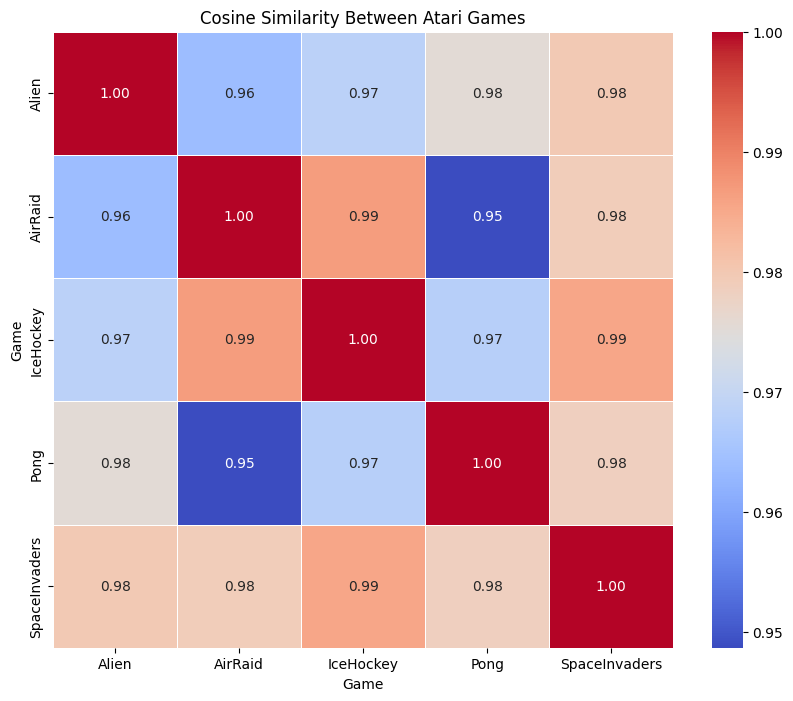

In [14]:
games = ["Alien", "AirRaid", "IceHockey", "Pong", "SpaceInvaders"]

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, xticklabels=games, yticklabels=games)
plt.title('Cosine Similarity Between Atari Games')
plt.xlabel('Game')
plt.ylabel('Game')
plt.show()

### BERT embeddings cosine similarity

In [15]:
# Forward pass to obtain BERT embeddings
with torch.no_grad():
    outputs = model(**tokens)
    hidden_states = outputs.last_hidden_state

# Calculate the mean of the hidden states across all tokens for each text
mean_hidden_states = torch.mean(hidden_states, dim=1).numpy()

In [16]:
mean_hidden_states.shape

(5, 768)

In [17]:
# Calculate cosine similarity
similarity_matrix = cosine_similarity(mean_hidden_states)
similarity_matrix

array([[0.9999998 , 0.94461125, 0.922144  , 0.90996635, 0.9523222 ],
       [0.94461125, 0.9999998 , 0.90685296, 0.9258394 , 0.9533044 ],
       [0.922144  , 0.90685296, 0.9999998 , 0.943207  , 0.9258189 ],
       [0.90996635, 0.9258394 , 0.943207  , 1.0000001 , 0.9432001 ],
       [0.9523222 , 0.9533044 , 0.9258189 , 0.9432001 , 1.0000001 ]],
      dtype=float32)

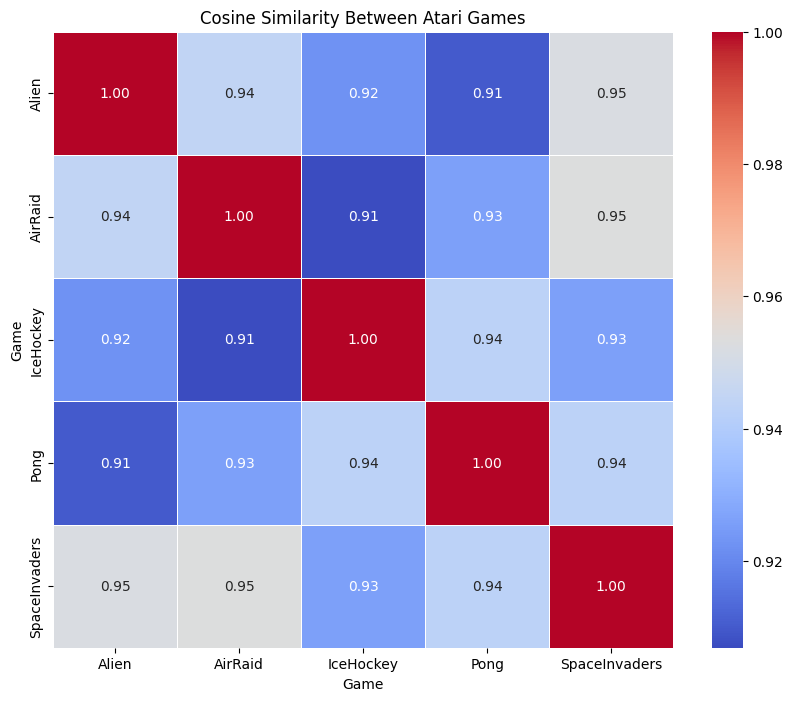

In [18]:
games = ["Alien", "AirRaid", "IceHockey", "Pong", "SpaceInvaders"]

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, xticklabels=games, yticklabels=games)
plt.title('Cosine Similarity Between Atari Games')
plt.xlabel('Game')
plt.ylabel('Game')
plt.show()

## Data analysis

In [21]:
data = load_data("../similarity_dataset", 0)

### Vectors length check

In [22]:
def check_len(dataframe, col, des_len):
    # Assuming data_tmp is your DataFrame and 'Action' is the column of vectors
    vectors = dataframe[col].tolist()

    # Iterate through the rest of the vectors and compare their lengths with the first one
    all_same_length = all(len(vector) == des_len for vector in vectors)

    if all_same_length:
        print("All vectors have the same length:", des_len)
    else:
        print("Not all vectors have the same length.")

In [23]:
check_len(data, 'Action', 512)

All vectors have the same length: 512


In [24]:
check_len(data, 'Reward', 512)

All vectors have the same length: 512


In [25]:
check_len(data, 'Text', 256)

All vectors have the same length: 256


### Min values analysis

In [26]:
def get_min_values_boxplot(dataframe, game, columns):

    dataframe_tmp = dataframe[dataframe['Game'] == game].copy(deep=True)

    for column in columns:
        min_values = np.min(dataframe_tmp[column].tolist(), axis=1)
        dataframe_tmp[f'{column}_min'] = min_values

    dataframe_tmp.boxplot(column=[f'{col}_min' for col in columns])
    plt.title(f'Boxplots of {game} Minimum Values')
    plt.ylabel('Min Value')
    plt.xlabel('Columns')
    plt.show()

    del dataframe_tmp

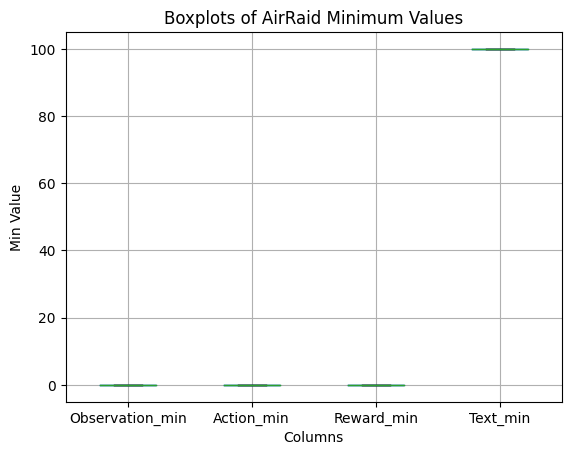

In [27]:
get_min_values_boxplot(data, 'AirRaid', ['Observation', 'Action', 'Reward', 'Text'])

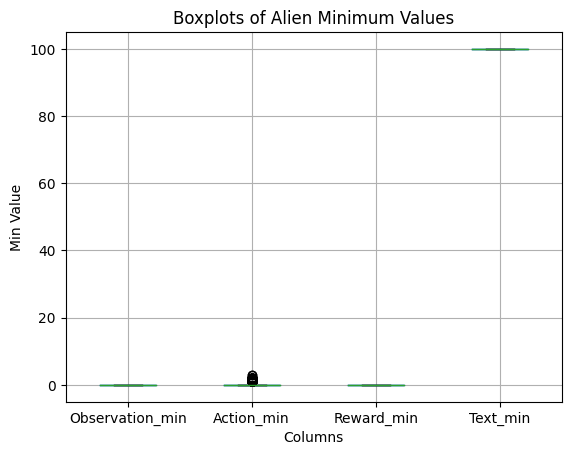

In [28]:
get_min_values_boxplot(data, 'Alien', ['Observation', 'Action', 'Reward', 'Text'])

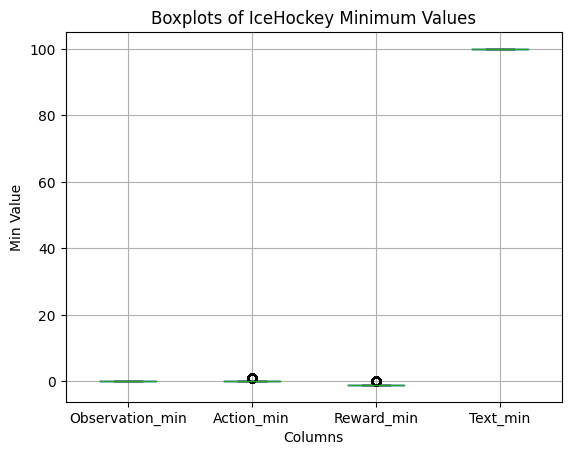

In [29]:
get_min_values_boxplot(data, 'IceHockey', ['Observation', 'Action', 'Reward', 'Text'])

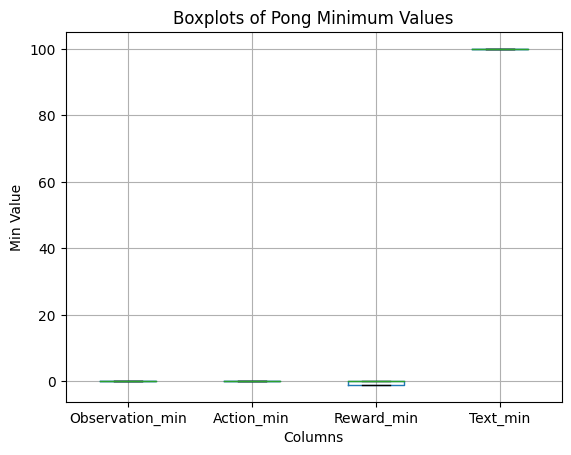

In [30]:
get_min_values_boxplot(data, 'Pong', ['Observation', 'Action', 'Reward', 'Text'])

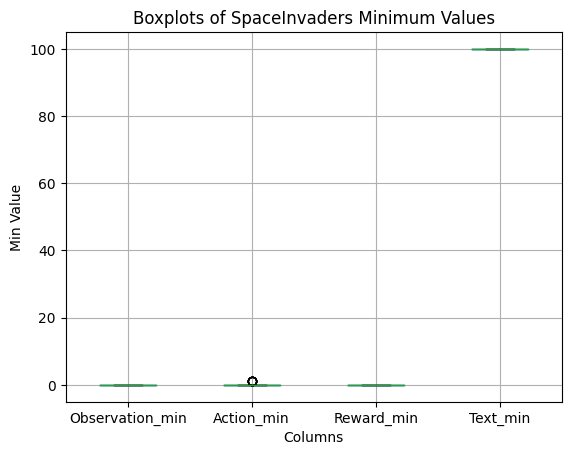

In [31]:
get_min_values_boxplot(data, 'SpaceInvaders', ['Observation', 'Action', 'Reward', 'Text'])

### Max values analysis

In [32]:
def get_max_values_boxplot(dataframe, game, columns):

    dataframe_tmp = dataframe[dataframe['Game'] == game].copy(deep=True)

    for column in columns:
        max_values = np.max(dataframe_tmp[column].tolist(), axis=1)
        dataframe_tmp[f'{column}_max'] = max_values

    dataframe_tmp.boxplot(column=[f'{col}_max' for col in columns])
    plt.title(f'Boxplots of {game} Maximum Values')
    plt.ylabel('Max Value')
    plt.xlabel('Columns')
    plt.show()

    del dataframe_tmp

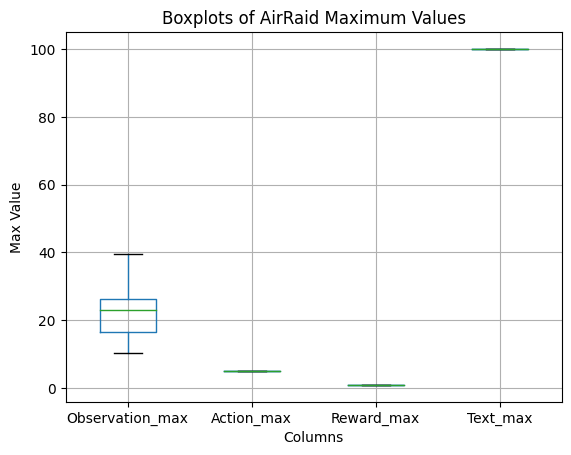

In [33]:
get_max_values_boxplot(data, 'AirRaid', ['Observation', 'Action', 'Reward', 'Text'])

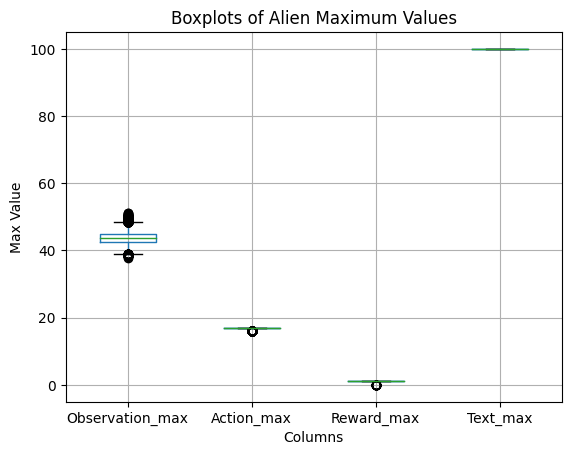

In [34]:
get_max_values_boxplot(data, 'Alien', ['Observation', 'Action', 'Reward', 'Text'])

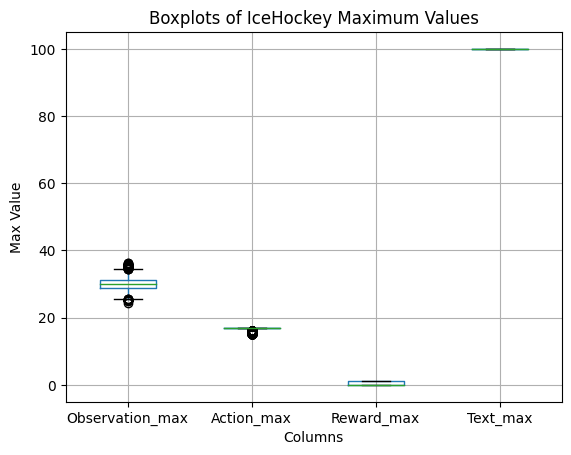

In [35]:
get_max_values_boxplot(data, 'IceHockey', ['Observation', 'Action', 'Reward', 'Text'])

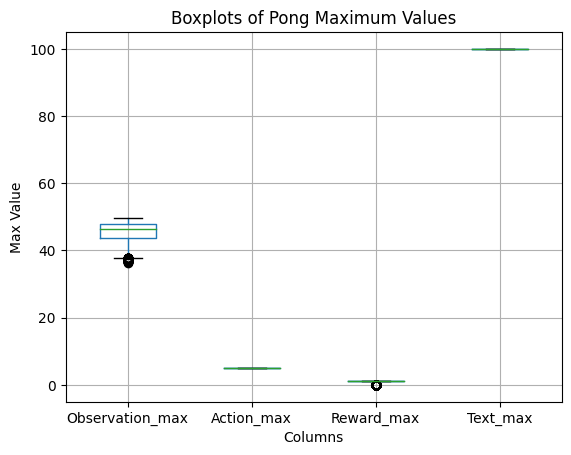

In [36]:
get_max_values_boxplot(data, 'Pong', ['Observation', 'Action', 'Reward', 'Text'])

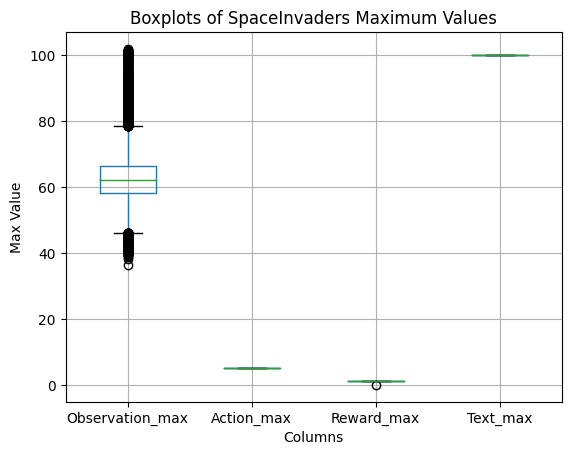

In [37]:
get_max_values_boxplot(data, 'SpaceInvaders', ['Observation', 'Action', 'Reward', 'Text'])

# Cumulative explained variance ratio (Tokenized)

## No norm

In [39]:
data = load_data("../similarity_dataset", 0)

# Function to concatenate elements of a list
def concatenate_elements(row):
    concatenated = []
    for column in data.columns:
        if column != 'Game':
            concatenated.extend(row[column])
    return concatenated

# Apply the function row-wise and create a new column
data['Feature'] = data.apply(concatenate_elements, axis=1)

# Convert lists in 'Feature' column to numpy arrays
data['Feature'] = data['Feature'].apply(lambda x: np.array(x))

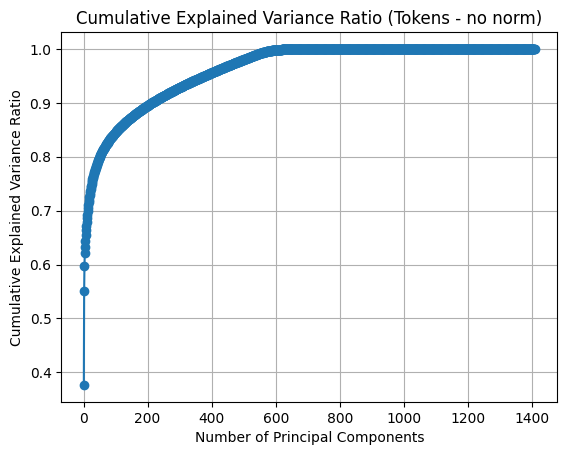

In [40]:
plot_cumulative_explained_variance_ratio(data, 'Feature', 'Cumulative Explained Variance Ratio (Tokens - no norm)')

## Min max

In [41]:
scaler = MinMaxScaler()
data['Feature_min_max'] = scaler.fit_transform(data['Feature'].to_list()).tolist()

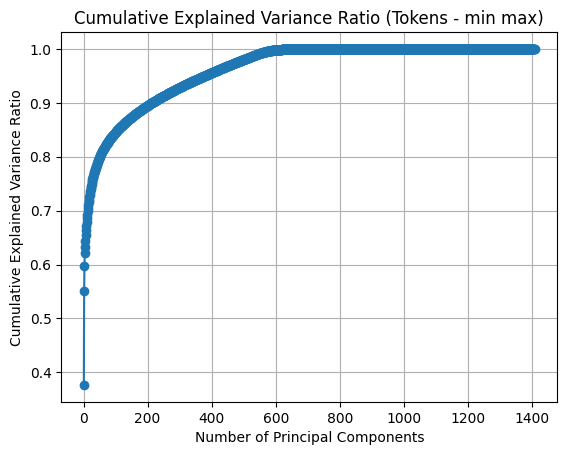

In [42]:
plot_cumulative_explained_variance_ratio(data, 'Feature', 'Cumulative Explained Variance Ratio (Tokens - min max)')

## Z-score

In [43]:
feature_column = np.array(data['Feature'].tolist())
mean_features = np.mean(feature_column, axis=0)
std_features = np.std(feature_column, axis=0)
zero_indices = np.where(std_features == 0)[0]
if len(zero_indices) > 0:
    # Drop elements from the vector at zero indices
    mean_features = np.delete(mean_features, zero_indices)
    std_features = np.delete(std_features, zero_indices)
    # Drop columns with zero indices
    feature_column = np.delete(feature_column, zero_indices, axis=1)

data['Feature_zscore'] = [(np.array(row) - mean_features) / std_features for row in feature_column]

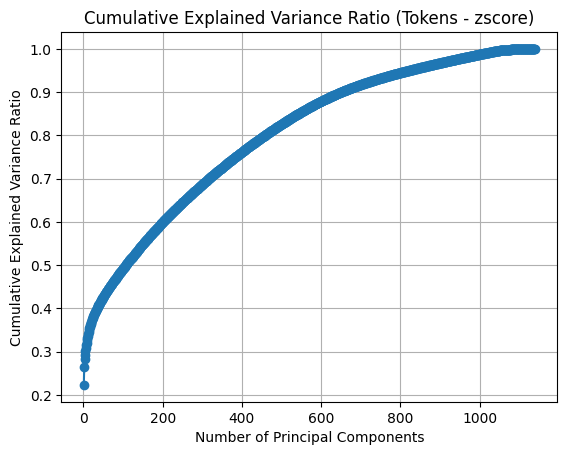

In [44]:
plot_cumulative_explained_variance_ratio(data, 'Feature_zscore', 'Cumulative Explained Variance Ratio (Tokens - zscore)')

# Cumulative explained variance ratio (CLS)

## No norm

In [46]:
data = load_data("../similarity_dataset", 1)

# Function to concatenate elements of a list
def concatenate_elements(row):
    concatenated = []
    for column in data.columns:
        if column != 'Game':
            concatenated.extend(row[column])
    return concatenated

# Apply the function row-wise and create a new column
data['Feature'] = data.apply(concatenate_elements, axis=1)

# Convert lists in 'Feature' column to numpy arrays
data['Feature'] = data['Feature'].apply(lambda x: np.array(x))

/storagenfs/a.capurso1/Master-Thesis/venv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


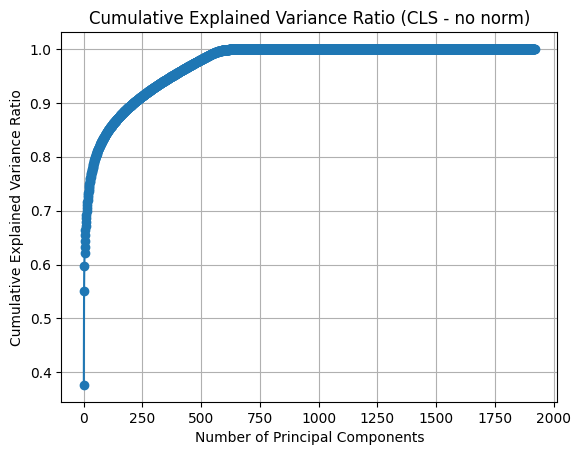

array([ 9.12117906e+03+0.00000000e+00j,  4.23896348e+03+0.00000000e+00j,
        1.11485403e+03+0.00000000e+00j, ...,
       -3.39671264e-15-6.18538435e-17j, -4.05170715e-15+0.00000000e+00j,
       -5.57263484e-15+0.00000000e+00j])

In [47]:
plot_cumulative_explained_variance_ratio(data, 'Feature', 'Cumulative Explained Variance Ratio (CLS - no norm)')

## Min max

In [48]:
scaler = MinMaxScaler()
data['Feature_min_max'] = scaler.fit_transform(data['Feature'].to_list()).tolist()

/storagenfs/a.capurso1/Master-Thesis/venv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


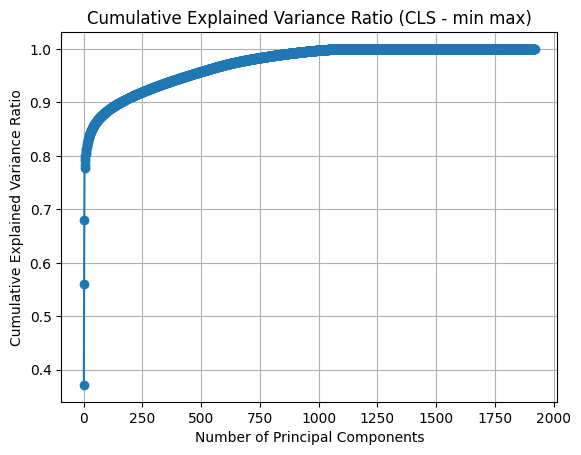

In [49]:
eigenvalues = plot_cumulative_explained_variance_ratio(data, 'Feature_min_max', 'Cumulative Explained Variance Ratio (CLS - min max)')

In [50]:
# Select number of components based on eigenvalues using the number of components that explain n% of the variance
total_variance = np.sum(eigenvalues)
explained_variance_ratio = eigenvalues / total_variance
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
num_components = np.argmax(cumulative_variance_ratio >= 1) + 1
num_components

1145

## Z-score

In [51]:
feature_column = np.array(data['Feature'].tolist())
mean_features = np.mean(feature_column, axis=0)
std_features = np.std(feature_column, axis=0)
zero_indices = np.where(std_features == 0)[0]
if len(zero_indices) > 0:
    # Drop elements from the vector at zero indices
    mean_features = np.delete(mean_features, zero_indices)
    std_features = np.delete(std_features, zero_indices)
    # Drop columns with zero indices
    feature_column = np.delete(feature_column, zero_indices, axis=1)

data['Feature_zscore'] = [(np.array(row) - mean_features) / std_features for row in feature_column]

/storagenfs/a.capurso1/Master-Thesis/venv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


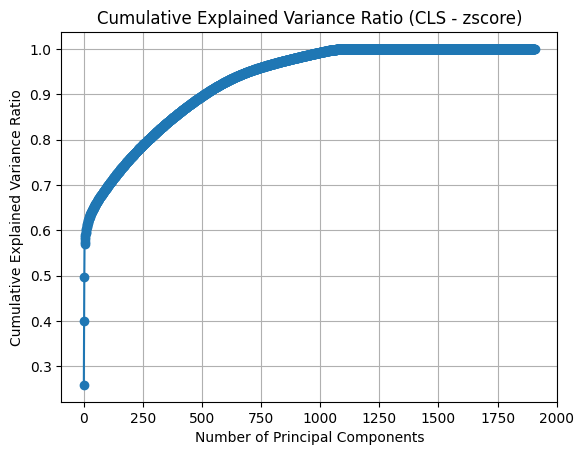

array([ 4.93071108e+02+0.j,  2.70558586e+02+0.j,  1.83289769e+02+0.j, ...,
       -1.86286556e-13+0.j, -1.88050944e-13+0.j, -1.92285651e-13+0.j])

In [52]:
plot_cumulative_explained_variance_ratio(data, 'Feature_zscore', 'Cumulative Explained Variance Ratio (CLS - zscore)')

# Cumulative explained variance ratio (BERT embeddings)

## No norm

In [53]:
data = load_data("../similarity_dataset", 2)

# Function to concatenate elements of a list
def concatenate_elements(row):
    concatenated = []
    for column in data.columns:
        if column != 'Game':
            concatenated.extend(row[column])
    return concatenated

# Apply the function row-wise and create a new column
data['Feature'] = data.apply(concatenate_elements, axis=1)

# Convert lists in 'Feature' column to numpy arrays
data['Feature'] = data['Feature'].apply(lambda x: np.array(x))

/storagenfs/a.capurso1/Master-Thesis/venv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


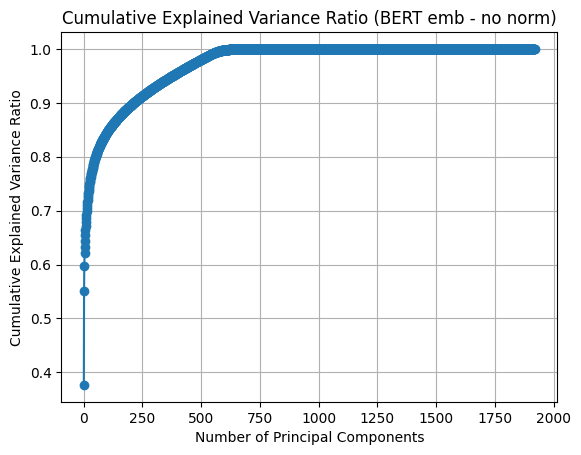

array([ 9.12002586e+03+0.00000000e+00j,  4.23769496e+03+0.00000000e+00j,
        1.11396111e+03+0.00000000e+00j, ...,
       -2.42825110e-15+9.37122733e-16j, -2.42825110e-15-9.37122733e-16j,
       -1.18182888e-13+0.00000000e+00j])

In [54]:
plot_cumulative_explained_variance_ratio(data, 'Feature', 'Cumulative Explained Variance Ratio (BERT emb - no norm)')

## Min max

In [55]:
scaler = MinMaxScaler()
data['Feature_min_max'] = scaler.fit_transform(data['Feature'].to_list()).tolist()

/storagenfs/a.capurso1/Master-Thesis/venv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


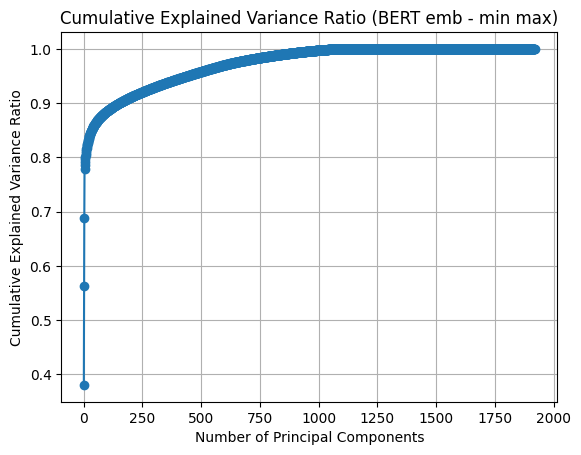

In [56]:
eigenvalues = plot_cumulative_explained_variance_ratio(data, 'Feature_min_max', 'Cumulative Explained Variance Ratio (BERT emb - min max)')

## Z-score

In [57]:
feature_column = np.array(data['Feature'].tolist())
mean_features = np.mean(feature_column, axis=0)
std_features = np.std(feature_column, axis=0)
zero_indices = np.where(std_features == 0)[0]
if len(zero_indices) > 0:
    # Drop elements from the vector at zero indices
    mean_features = np.delete(mean_features, zero_indices)
    std_features = np.delete(std_features, zero_indices)
    # Drop columns with zero indices
    feature_column = np.delete(feature_column, zero_indices, axis=1)

data['Feature_zscore'] = [(np.array(row) - mean_features) / std_features for row in feature_column]

/storagenfs/a.capurso1/Master-Thesis/venv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


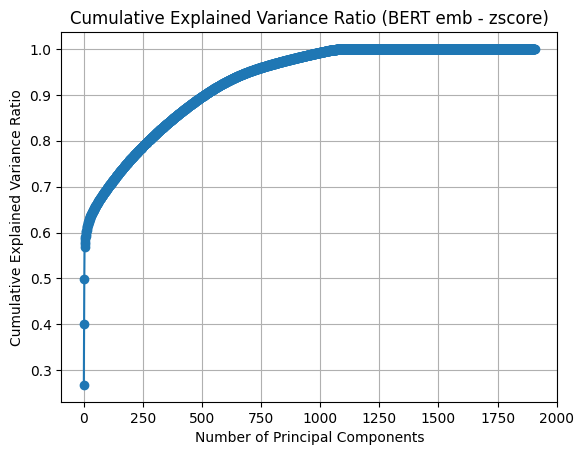

array([ 5.10889673e+02+0.j,  2.52587233e+02+0.j,  1.89058969e+02+0.j, ...,
       -2.00380838e-13+0.j, -2.02242080e-13+0.j, -2.06895144e-13+0.j])

In [58]:
plot_cumulative_explained_variance_ratio(data, 'Feature_zscore', 'Cumulative Explained Variance Ratio (BERT emb - zscore)')

# Best clustering with the first 1145 PC (CLS - Min max)

## K-means

In [9]:
num_components = 1145
feature_matrix = np.array(data['Feature_min_max'].tolist())

In [10]:
# Perform PCA on the first k principal components
pca = PCA(n_components=num_components)
principal_components = pca.fit_transform(feature_matrix)
X = np.vstack(principal_components)

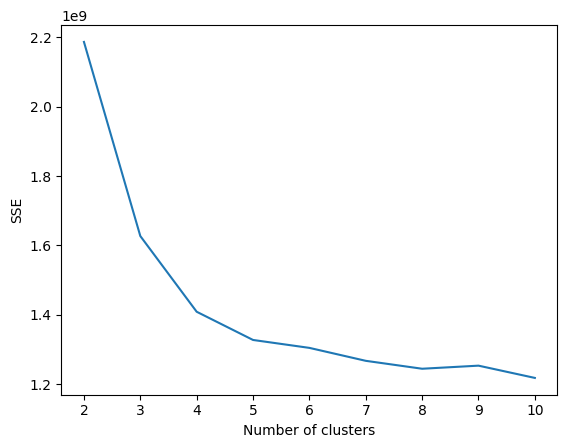

In [12]:
find_optimal_k(X, max_k=10)

In [11]:
# Fit KMeans clustering
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

/storagenfs/a.capurso1/Master-Thesis/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=4, random_state=42)

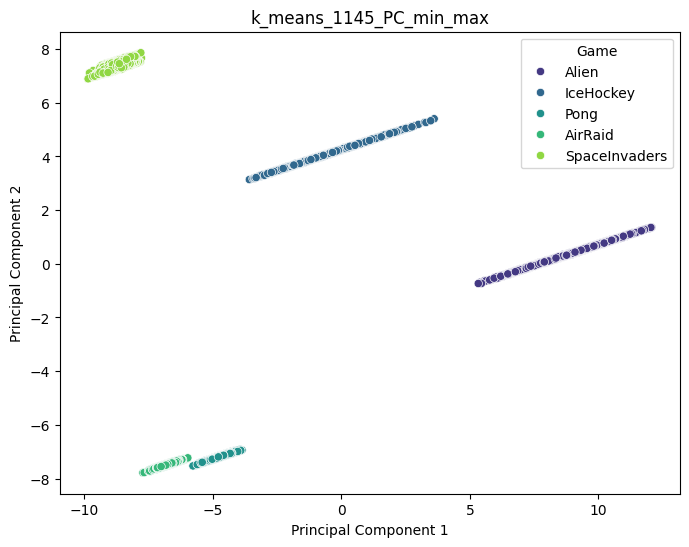

In [12]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=data['Game'], palette='viridis', legend='full')

plt.title(f'k_means_{num_components}_PC_min_max')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Game')
plt.show()

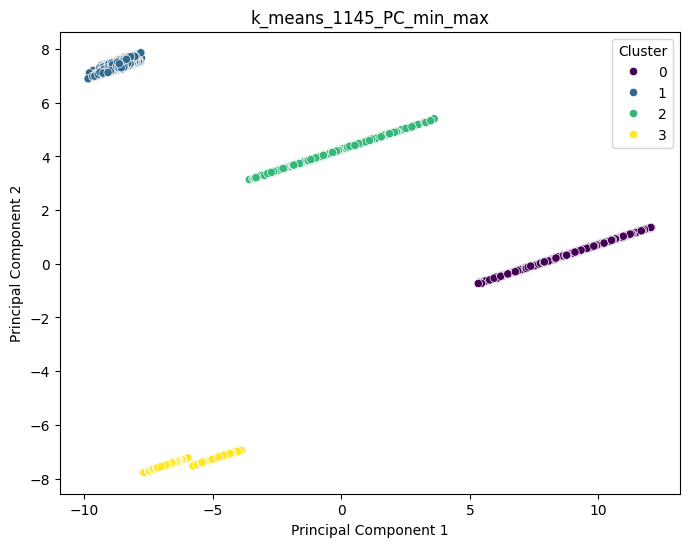

In [13]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=kmeans.labels_, palette='viridis', legend='full')

plt.title(f'k_means_{num_components}_PC_min_max')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

## Cosine similarity

In [6]:
games = data['Game'].unique()

game_similarity = pd.DataFrame(index=games, columns=games)

for i in range(len(games)):
    for j in range(len(games)):

        combined_vectors_game1 = np.stack(data[data['Game'] == games[i]]['Feature_min_max'].tolist())
        combined_vectors_game2 = np.stack(data[data['Game'] == games[j]]['Feature_min_max'].tolist())

        # Compute cosine similarity matrix
        cosine_sim_matrix = cosine_similarity(combined_vectors_game1, combined_vectors_game2)
        
        # Take the mean cosine similarity
        mean_cosine_similarity = np.mean(cosine_sim_matrix)

        game_similarity.loc[games[i], games[j]] = mean_cosine_similarity

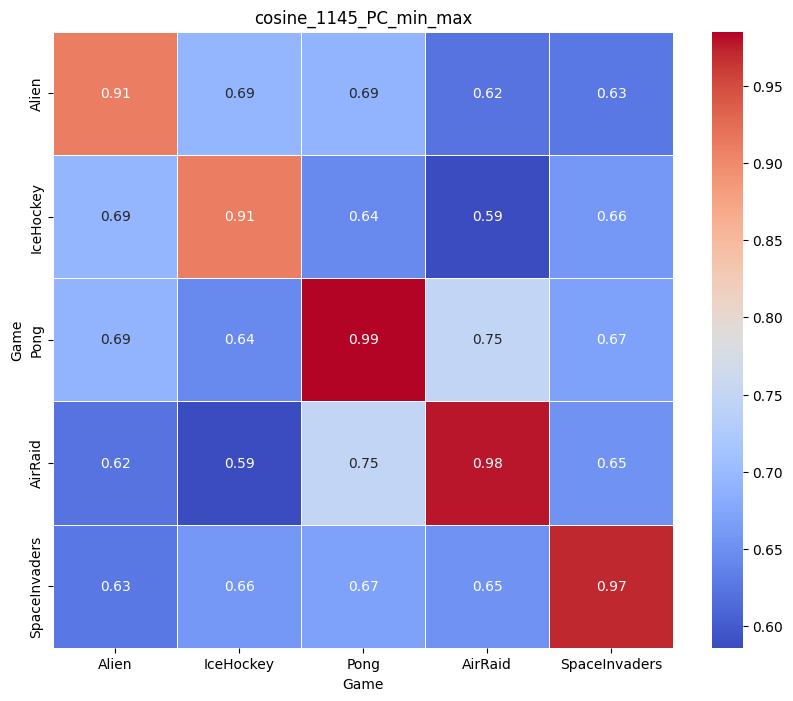

In [10]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(game_similarity.astype(float), annot=True, cmap='coolwarm', linewidths=.5)
plt.title(f'cosine_{num_components}_PC_min_max')
plt.xlabel('Game')
plt.ylabel('Game')
plt.show()